In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [19]:
class Neural_Network(object):
    def __init__(self):
        # hyperparameters
        self.random = np.random.RandomState(2018)
        self.hiddenLayerSize = 100
        self.epochs = 10000
        self.minibatches = 1
        self.learning_rate = 0.01
        self.Lambda = 0.001  # regularization parameter
        
    # preprocessing data
    
    def onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for i, val in enumerate(y.astype(int)):
            onehot[val, i] = 1
        return onehot.T
    
    def minmaxScaler(self, X_train, X_test):
        scaler = MinMaxScaler(feature_range=(0, 1), copy=True)
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)
        return X_train_std, X_test_std
    
    # activation functions and derivatives
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def sigmoidPrime(self, z):
        return z * (1 - z)
    
    # forward propagation
    
    def forward(self, X):
        z_h = np.dot(X, self.W1) + self.b_h
        a_h = self.sigmoid(z_h)
        z_out = np.dot(a_h, self.W2) + self.b_out
        a_out = self.sigmoid(z_out)
        return z_h, a_h, z_out, a_out
    
    def predict(self, X):
        z_hidden, a_hidden, z_out, a_out = self.forward(X)
        y_pred = np.argmax(a_out, axis=1)
        return y_pred
    
    # cost function
    
    def costFunction(self, y_target, y_hat):
        l2 = (self.Lambda * (np.sum(self.W1**2) + np.sum(self.W2**2)))
        c1 = -y_target * (np.log(y_hat + 1e-8))
        c2 = (1.-y_target)*np.log(1.-y_hat + 1e-8)
        cost = np.sum(c1-c2) + 12
        return cost
    
    def fit(self, X_train, y_train, X_test, y_test):
        n_classes = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        
        # preprocessing the data
        y_train_enc = self.onehot(y_train, n_classes)
        y_test_enc = self.onehot(y_test, n_classes)
        
        X_train, X_test = self.minmaxScaler(X_train, X_test)
        
        # weights (parameters)
        self.b_h = np.zeros(self.hiddenLayerSize)
        self.W1 = self.random.normal(loc=0.0, scale=0.1,
                                    size=(n_features, self.hiddenLayerSize))
        self.b_out = np.zeros(n_classes)
        self.W2 = self.random.normal(loc=0.0, scale=0.1,
                                    size=(self.hiddenLayerSize, n_classes))
        self.eval = {'cost_train': [], 'cost_test': [], 'train_acc': [], 'test_acc': []}
        
        for i in range(self.epochs):
            
            batch = np.array_split(range(y_test.shape[0]), self.minibatches)
            
            for idx in batch:
                # forward propagation
                z_h, a_h, z_out, a_out = self.forward(X_train[idx])
                
                # backpropragation
                sigma_out = (a_out - y_train_enc[idx])
                sigma_h = np.dot(sigma_out, self.W2.T) * self.sigmoidPrime(a_h)
                
                grad_W1 = np.dot(X_train[idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                grad_W2 = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                # regularization and weight updates
                
                delta_W1 = grad_W1 + self.Lambda * self.W1
                delta_b_h = grad_b_h  # we don't need to regularize the bias
                self.W1 -= self.learning_rate * delta_W1
                self.b_h -= self.learning_rate * delta_b_h

                delta_W2 = grad_W2 + self.Lambda * self.W2
                delta_b_out = grad_b_out
                self.W2 -= self.learning_rate * delta_W2
                self.b_out -= self.learning_rate * delta_b_out
            
            # evaluation
            z_h, a_h, z_out, a_out_train = self.forward(X_train)
            z_h_test, a_h_test, z_out_test, a_out_test = self.forward(X_test)

            cost_train = self.costFunction(y_train_enc, a_out_train)
            cost_test = self.costFunction(y_test_enc, a_out_test)

            y_train_pred = self.predict(X_train)
            y_test_pred = self.predict(X_test)

            train_acc = (np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0]
            test_acc = (np.sum(y_test == y_test_pred)).astype(np.float) / X_test.shape[0]

            self.eval['cost_train'].append(cost_train)
            self.eval['cost_test'].append(cost_test)
            self.eval['train_acc'].append(train_acc)
            self.eval['test_acc'].append(test_acc)

            if i % 1000 == 0:
                print('training-acc: %.2f' % train_acc)
                print('test-acc: %.2f' % test_acc)
            
        print("Confusion_matrix: \n", confusion_matrix(y_test, y_test_pred))
        print("Classification_report: \n", classification_report(y_test, y_test_pred))

        return self.eval
    
    # plotting cost functions for training and testing
    
    def plot(self, cost_train, cost_test, train_acc, test_acc):
        fig, ax = plt.subplots(2, 1, figsize=(10,8))
        ax[0].plot(np.arange(len(cost_train)), cost_train, lw=2, color='blue', label='CostTraining')
        ax[0].plot(np.arange(len(cost_test)), cost_test, lw=2, color='red', label='CostTest')
        ax[0].legend(loc='best')
        ax[0].set_ylabel('Cost')
        ax[0].set_xlabel('Cycles')
        
        ax[1].plot(np.arange(len(train_acc)), train_acc, lw=2, color='blue', label='Training Accuracy %')
        ax[1].plot(np.arange(len(test_acc)), test_acc, lw=2, color='red', label='Test Accuracy %')
        ax[1].legend(loc='best')
        ax[1].set_ylabel('Accuracy')
        ax[1].set_xlabel('Cycles')
        
        return plt.show()



Testing the model:

In [20]:
NN = Neural_Network()

In [26]:
digits = load_digits()

In [27]:
X = digits.data.shape
y = digits.target

In [28]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3, random_state=2018)

In [29]:
eval = NN.fit(X_train, y_train, X_test, y_test)

/var/folders/8r/l_mpbfw92dg3t3vhkp57yndm0000gn/T/ipykernel_15758/2330915931.py:115: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_acc = (np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0]
/var/folders/8r/l_mpbfw92dg3t3vhkp57yndm0000gn/T/ipykernel_15758/2330915931.py:116: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


training-acc: 0.10
test-acc: 0.09
training-acc: 0.95
test-acc: 0.94
training-acc: 0.95
test-acc: 0.94
training-acc: 0.95
test-acc: 0.94
training-acc: 0.95
test-acc: 0.94
training-acc: 0.95
test-acc: 0.95
training-acc: 0.95
test-acc: 0.95
training-acc: 0.95
test-acc: 0.95
training-acc: 0.95
test-acc: 0.95
training-acc: 0.95
test-acc: 0.95
Confusion_matrix: 
 [[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  2  1  1  0  1  2]
 [ 0  1 51  0  0  0  0  0  0  0]
 [ 0  0  1 56  0  1  0  0  1  2]
 [ 0  0  0  0 48  0  0  1  0  0]
 [ 0  0  0  0  0 48  1  0  0  1]
 [ 0  0  0  0  0  0 60  0  0  0]
 [ 0  0  0  1  1  1  0 48  0  1]
 [ 0  1  2  0  0  0  1  2 45  0]
 [ 0  0  0  0  0  0  0  0  1 57]]
Classification_report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.88      0.92        57
           2       0.94      0.98      0.96        52
           3       0.98      0.92      0.95        61
           4 

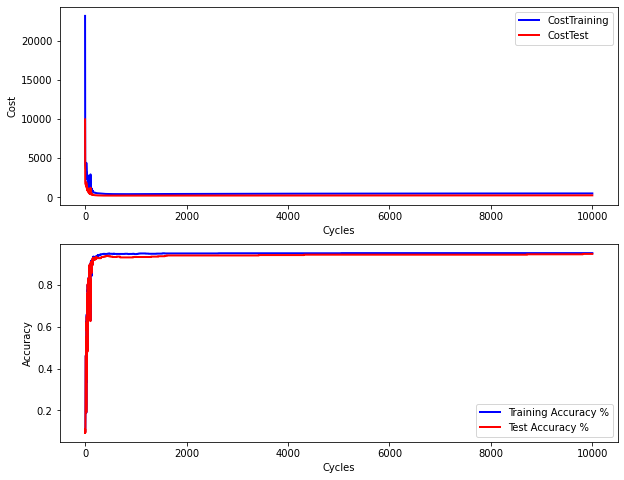

In [30]:
NN.plot(eval['cost_train'], eval['cost_test'], eval['train_acc'], eval['test_acc'])